In [1]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [2]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[-2.]
[-1. -1. -8.]


In [3]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[-0.84232201 -0.53897462 -0.68697714]
[0.19525401]
[-0.86973891 -0.49351214 -1.06192   ] -6.664336522944153 False {}


In [12]:
# Learning episodes
epochs = 10000

# Numbers of decimals for discretization
decimals = 2

Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


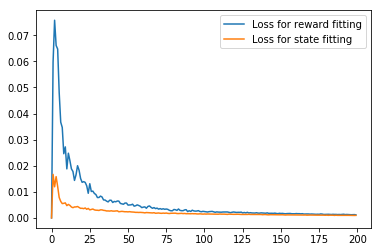

In [5]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()

print("Regression...")
for i in range(epochs):
    #observation = env.reset() # do we really need to call this every episode?
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    #observation = state
    if i%50==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [6]:
"""
    Discretization
    
    We translate the state from [-1, 1] [-1, 1] [-8, 8]
    to [0, 2] [0, 2] [0, 16]
    
    We translate the actions from [-2, 2] to [0, 4]
    
    Then we round the input with variable number of decimal places
    and multiply by 10 to the power of this number
    to make sure we get only positive integers
    
"""

def discretization(state_action, x, decimal_number):
    if state_action=="state":
        positive_s = [x[0]+1, x[1]+1, x[2]+8]
        rounded_s = np.around(positive_s, decimals=decimal_number)
        int_s = rounded_s * (10**decimal_number)
        int_s = np.array([int(int_s[0]), int(int_s[1]), int(int_s[2])])
        return int_s
    if state_action=="action":
        positive_a = x + 2
        rounded_a = np.around(positive_a, decimals=decimal_number)
        int_a = int(rounded_a * (10**decimal_number))
        return int_a
    else:
        print("Unknown discretization")
        return -1

In [7]:
"""
   Value Iteration
   
"""

'\n   Value Iteration\n   \n'

In [ ]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

def policy_iteration(theta):
    
    # Determine size of value function and policy lookup table
    state_space_size = (2*(10**decimals), 2*(10**decimals), 16*(10**decimals))
    
    # Initialize value function and policy arbitrarily
    value_function = np.ones(shape=state_space_size)
    policy = np.ones(shape=state_space_size)
    
    print ("Policy iteration...")
    
    def policy_evaluation(theta):
        print("Evaluating policy")
        delta = theta
        while delta >= theta:
            delta = 0
            for s0 in range(state_space_size[0]):
                for s1 in range(state_space_size[1]):
                    for s2 in range(state_space_size[2]):
                        v = value_function[s0, s1, s2]
                        value_function[s0, s1, s2] = 0 # TODO
                        delta = max(delta, v - value_function[s0, s1, s2])
    
    
    def policy_improvement():
        print("Improving policy")
        policy_stable = true
        for s0 in range(state_space_size[0]):
                for s1 in range(state_space_size[1]):
                    for s2 in range(state_space_size[2]):
                        old_action = policy[s0, s1, s2]
                        policy[s0, s1, s2] = 0 # TODO
                        if old_action != policy[s0, s1, s2]:
                            policy_stable = false
        if policy_stable:
            return 1
        else:
            return 0
        
    # Run until policy is stable
    stable_policy = 0
    while stable_policy == 0:
        policy_evaluation(theta)
        stable_policy = policy_improvement()
            
    print("...done")
    return value_function, policy
    
policy_iteration(theta=0.1)


Policy iteration...
Evaluating policy


In [10]:
"""
    Some stuff to see the predictions and discretization in action

"""
state = env.reset()

for _ in range(10):
    #env.render()
    print("Old state: ", discretization("state", state, decimals))
    action = env.action_space.sample()
    print("Action: ", discretization("action", action, decimals))
    state, reward, done, info = env.step(action)
    x = np.append(state,action)
    x = x.reshape(1,-1)
    print("Predicted reward: ", regressorReward.predict(x))
    print("Observed reward: ", reward)
    print("Predicted next state: ", discretization("state", regressorState.predict(x).T, decimals))
    print("Observed next state: ", discretization("state", state, decimals))
    print()

env.close()

Old state:  [142   9 807]
Action:  15
Predicted reward:  [-1.49330717]
Observed reward:  -1.307384263808462
Predicted next state:  [135   7 631]
Observed next state:  [138   7 711]

Old state:  [138   7 711]
Action:  5
Predicted reward:  [-1.97142497]
Observed reward:  -1.4897456601933659
Predicted next state:  [121   2 522]
Observed next state:  [129   4 612]

Old state:  [129   4 612]
Action:  399
Predicted reward:  [-2.55359743]
Observed reward:  -1.994619384197326
Predicted next state:  [106   1 498]
Observed next state:  [118   2 570]

Old state:  [118   2 570]
Action:  195
Predicted reward:  [-3.37125706]
Observed reward:  -2.4736399569867635
Predicted next state:  [ 84   1 415]
Observed next state:  [102   0 496]

Old state:  [102   0 496]
Action:  149
Predicted reward:  [-4.49621578]
Observed reward:  -3.3197227886341683
Predicted next state:  [ 62   8 326]
Observed next state:  [ 83   1 413]

Old state:  [ 83   1 413]
Action:  78
Predicted reward:  [-6.41054786]
Observed rewar